In [11]:
import numpy as np
import pandas as pd
import odbo

In [12]:
threshold = 0.05
data_train = pd.read_csv('../datasets/GB1_2016_384.csv', sep=',')

#load data
name_pre, Y_train = np.array(data_train['AACombo']), np.array(data_train['Fitness'])
name = odbo.utils.code_to_array(name_pre)

# Using average measurement results as features
feature_model = odbo.featurization.AvgMeasurement(raw_vars=name, Y=Y_train)
X_train = feature_model.transform(name)

# Find the adaptive search space model
labels_train = odbo.prescreening.sp_label(X_train, Y_train, thres=threshold)
pre_model = odbo.prescreening.XGBOD(eval_metric = 'error')
pre_model.fit(X_train, labels_train)
pred_labels = pre_model.predict(X_train)

/usr/local/lib/python3.7/site-packages/pyod/models/base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")
/usr/local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:07:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [7]:
# Predict the adaptive search space of the problem
data_test = pd.read_csv('../datasets/GB1_2016_149361.csv', sep=',')
name_pre, Y_test = np.array(data_test['AACombo']), np.array(data_test['Fitness'])
name = odbo.utils.code_to_array(name_pre)
X_test = feature_model.transform(name)
labels_test = odbo.prescreening.sp_label(X_test, Y_test, thres=0.05)
pred_test_labels = pre_model.predict(X_test)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Correct ratio: 92.174%
FN ratio: 5.998%
FP ratio: 1.828%


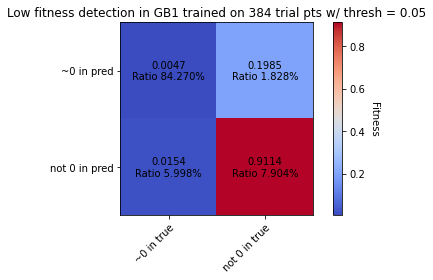

In [10]:
# Plot the confusion matrix (will be moved as a plot function)
from matplotlib import cm
import matplotlib.pyplot as plt

c1, c2, c3, c4=[],[],[],[]
id1, id2, id3, id4 = [], [], [], []
for i in range(len(pred_test_labels)):
    if pred_test_labels[i]==0 and labels_test[i] ==0:
        c1.extend(Y_test[i].ravel())
        id1.append(i)
    elif pred_test_labels[i]==1 and labels_test[i] ==0:
        c2.extend(Y_test[i].ravel())
        id2.append(i)
    elif pred_test_labels[i]==1 and labels_test[i] ==1:
        c3.extend(Y_test[i].ravel())
        id3.append(i)
    else:
        c4.extend(Y_test[i].ravel())
        id4.append(i)        
ids = []
ids.append(id1)
ids.append(id2)
ids.append(id3)
ids.append(id4)

#np.save("xgbod_pred_ids.npy", ids)
# Plot
true =['~0 in true', 'not 0 in true']
pred =['~0 in pred', 'not 0 in pred']
avg = np.array([[np.mean(c3), np.mean(c2)],[np.mean(c4), np.mean(c1)]])
count = np.array([[len(c3), len(c2)],[len(c4), len(c1)]])
fig, ax = plt.subplots()
im = ax.imshow(avg, cmap=cm.coolwarm)

# We want to show all ticks...
ax.set_xticks(np.arange(len(true)))
ax.set_yticks(np.arange(len(pred)))
# ... and label them with the respective list entries
ax.set_xticklabels(true)
ax.set_yticklabels(pred)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(pred)):
    for j in range(len(true)):
        text = ax.text(j, i, str(round(avg[i,j], 4)) +'\nRatio {0:.3%}'.format(count[i,j]/149361, 4),
                       ha="center", va="center", color="k")

cbar = ax.figure.colorbar(im, ax=ax, cmap="YlGn")
cbar.ax.set_ylabel('Fitness', rotation=-90, va="bottom")
ax.set_title("Low fitness detection in GB1 trained on 384 trial pts w/ thresh = %.2f" %threshold)
fig.tight_layout()
fig.show()
print("Correct ratio: {0:.3%}".format((len(c3)+len(c1))/149361))
print("FN ratio: {0:.3%}".format(len(c4)/149361))
print("FP ratio: {0:.3%}".format(len(c2)/149361))    
    